In [ ]:
from globalConstants import * 
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [10]:
dq.set_device('cpu')
dq.set_precision('simple')

|██████████| 100.0% ◆ elapsed 252.55ms ◆ remaining 0.00ms  
100%|██████████| 50/50 [00:02<00:00, 21.84it/s]


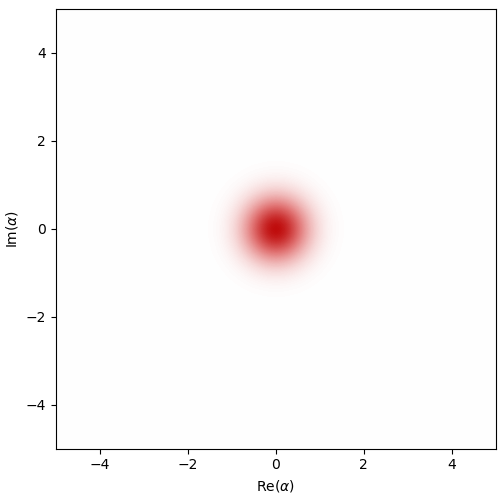

In [14]:

# Define a gate simulation time. (For instance, we choose T_gate = 4)
T_gate = 4.0
# Define a new time vector for the gate simulation
t_save_gate = jnp.linspace(0, T_gate, 50)

# Compute the cat amplitude, which (in our conventions) is given by:
alpha = jnp.sqrt(-eps / g2)

# Define the stabilization Hamiltonian (same as in Task 1.1)
H_stab = g2 * dq.dag(a) @ dq.dag(a) @ b \
         + jnp.conj(g2) * a @ a @ dq.dag(b) \
         + jnp.conj(eps) * b + eps * dq.dag(b)

# Define the additional Hamiltonian to perform the Zeno gate.
# Here we use a modulated drive on mode a. The modulation function is chosen so that,
# over time T_gate, the rotation will map the + to the – cat state.
H_Z = dq.modulated(lambda t: jnp.pi * t / (8 * alpha * T_gate), (dq.dag(a) + a))

# The total Hamiltonian during the gate operation:
H_total = H_stab + H_Z

# For now we assume only buffer loss is active (jump operator for mode b):
jump_ops = [jnp.sqrt(Kb) * b]

# Solve the master equation for the total Hamiltonian:
res_gate = dq.mesolve(H_total, jump_ops, psi0, t_save_gate)

# Compute the reduced state of the memory (mode a) by tracing over mode b:
rho_a_gate = dq.ptrace(res_gate.states, 0, res_gate.states.dims)

# Display the evolution via the Wigner function as a GIF:
dq.plot.wigner_gif(rho_a_gate, fps=120)



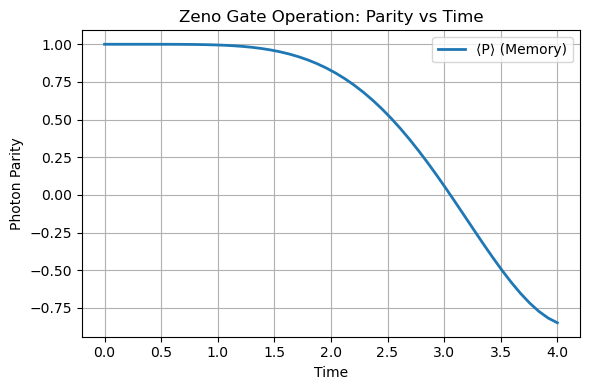

In [15]:
# --- Now, compute and plot the parity of the memory mode during the gate operation ---

# Define a helper function to generate the parity diagonal (for a Hilbert space of dimension n):
def parity_diag(n):
    # Use complex64 to be consistent with our jax precision settings.
    return jnp.array([(-1)**i for i in range(n)], dtype=jnp.complex64)

# Create the parity operator for mode a.
parity_matrix = jnp.diag(parity_diag(na))
Pa_a = dq.asqarray(parity_matrix, dims=(na,))
# Identity on mode b:
Ib = dq.eye(nb)
# The full parity operator is the tensor product of the mode-a parity with identity on b:
PaOp = dq.tensor(Pa_a, Ib)

# Compute parity expectation values along the gate evolution:
parity_expect_gate = [dq.expect(PaOp, state).real for state in res_gate.states]

plt.figure(figsize=(6, 4))
plt.plot(t_save_gate, parity_expect_gate, lw=2, label="⟨P⟩ (Memory)")
plt.xlabel("Time")
plt.ylabel("Photon Parity")
plt.title("Zeno Gate Operation: Parity vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

|██████████| 100.0% ◆ elapsed 375.55ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 366.00ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 401.13ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 413.80ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 426.80ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 447.64ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 931.52ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 6.50s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 374.78ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 373.90ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 405.43ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 426.99ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 434.86ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 569.06ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 852.42ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 6.49s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 364.96ms ◆ remai

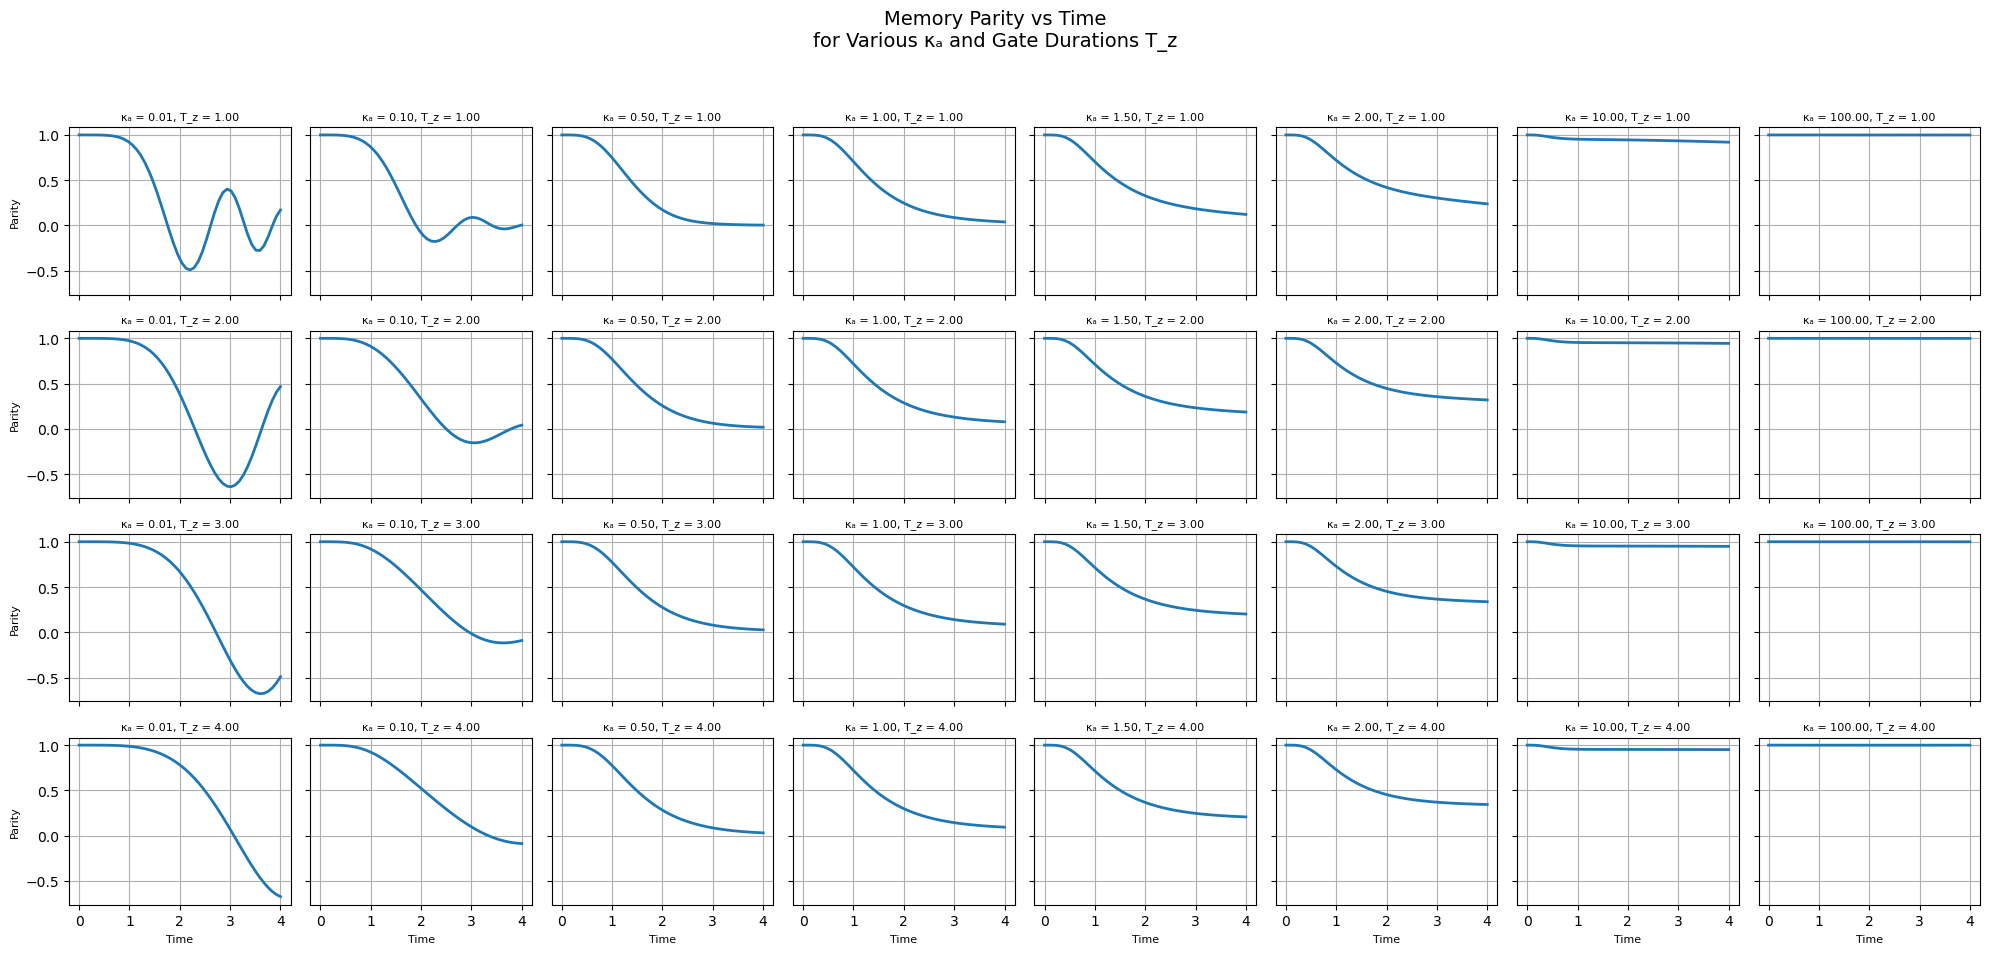

In [13]:
# Define a set of single-photon loss rates (κₐ) to test:
Ka_values = jnp.array([0.01, 0.1, 0.1, 1.0, 10.0, 100.0])
# Define several effective gate-duration parameters T_z:
Tz_values = jnp.linspace(1.0, 4.0, 4)  # e.g. [1.0, 2.0, 3.0, 4.0]

# Prepare a grid of subplots: rows for different T_z, columns for different κₐ
fig, axes = plt.subplots(len(Tz_values), len(Ka_values), figsize=(20, 10), sharex=True, sharey=True)
fig.suptitle("Memory Parity vs Time\nfor Various κₐ and Gate Durations T_z", fontsize=14)

# Loop over the effective gate durations and the memory loss rates:
for i, Tz in enumerate(Tz_values):
    # Define the modulated drive for the current T_z.
    # (Note: We use the same form as before but now replace T_gate with Tz.)
    H_Z_Tz = dq.modulated(lambda t, Tz=Tz: jnp.pi * t / (8 * alpha * Tz), (dq.dag(a) + a))
    # Total Hamiltonian for the current T_z:
    H_total_Tz = H_stab + H_Z_Tz
    
    for j, Ka in enumerate(Ka_values):
        # Now include both the buffer loss and the memory single-photon loss:
        jump_ops = [jnp.sqrt(Kb) * b, jnp.sqrt(Ka) * a]
        
        # Solve the master equation with the current parameters.
        # We also pass PaOp as an expectation operator if desired.
        res_param = dq.mesolve(H_total_Tz, jump_ops, psi0, t_save_gate)
        
        # Extract the parity expectation (compute explicitly):
        parity_vals = [dq.expect(PaOp, state).real for state in res_param.states]
        
        # Plot the parity vs time in the corresponding subplot:
        ax = axes[i, j]
        ax.plot(t_save_gate, parity_vals, lw=2)
        ax.set_title(f"κₐ = {Ka:.2f}, T_z = {Tz:.2f}", fontsize=8)
        ax.grid(True)
        if i == len(Tz_values) - 1:
            ax.set_xlabel("Time", fontsize=8)
        if j == 0:
            ax.set_ylabel("Parity", fontsize=8)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()